<footer id="footer"></footer>

<h1 align='center'>Transformers. GPT2</h1>
<p align="center"><img src="https://drive.google.com/uc?id=11waqtrUYQ9JqP4NMuy-eN1SHTd80MTpu"  border="0"></a></p>







<b> **Baseline** подготовлен [Deep learning school](https://www.dlschool.org/pro-track)

Поработаем с моделями трансформеров и с библиотекой `HuggingFace🤗`. В этом задании необходимо решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. 

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
!pip install -q transformers datasets tokenizers

In [ ]:
import torch
import random
import torch.nn as nn
import warnings
import numpy as np
from matplotlib import ticker
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset



from transformers import (
                          GPT2ForSequenceClassification, 
                          GPT2TokenizerFast, 
                          GPT2Config,
                          get_linear_schedule_with_warmup
)



warnings.filterwarnings("ignore")
plt.style.use('dark_background')

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

print(f"Device type for current runtime is {device}")

Device type for current runtime is cuda


In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)


def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=12)
    ax.set_yticklabels(['']+seq, fontsize=12)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Необходимо подготовить класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения. Посмотрим как работает токенайзер, чтобы потом написать необходимый класс

<font size="2">[reference](https://huggingface.co/transformers/main_classes/tokenizer.html)</font>

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256,  

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):

        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        tokenizer_output = tokenizer.encode_plus(text, 
                                                 max_length = self.max_length,
                                                 return_token_type_ids=False,
                                                 pad_to_max_length=True,
                                                 return_tensors="pt",
                                                 return_attention_mask=True,
                                                 truncation=True
                                                 )

        target = self.label2num[label]

        return {
            "input_ids": tokenizer_output["input_ids"].flatten(), 
            "attention_mask": tokenizer_output["attention_mask"].flatten(),
            "labels": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation")
test_dataset = TweetDataset("test")

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, 
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Fine tuning

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config) # GPT2 для классификации текста
model_0.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

Подготовь оптимайзер и критерий:

In [ ]:
lr = 2e-5
optimizer = torch.optim.AdamW(model_0.parameters(), weight_decay=0.005)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
batch = next(iter(train_loader))

model_0 = model_0.to(device)

outputs = model_0(
        input_ids=batch['input_ids'].to(device),
        attention_mask=batch['attention_mask'].to(device),
        labels=batch['labels'].to(device)
)

In [ ]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'attentions'])

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

Обучим модель с помощью `train_dataset`, проверять качество во время обучения будем с помощью `valid_dataset` , финальное посмотрим на `test_dataset`.

In [ ]:
clip = 1
num_epochs = 20
# scheduler
total_steps = len(train_loader) * num_epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# train
for e in range(num_epochs):
    
    model_0.train()
    train_loss = 0
    correct_predictions = 0
    processed_train = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    pbar.set_description(f"Epoch {e + 1}")
    for idx, batch in pbar:

        optimizer.zero_grad()
        # либо передать **batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch["labels"].to(device)

        outputs = model_0(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
          )
        # ['loss', 'logits', 'past_key_values', 'attentions']
        loss, logits = outputs[:2]
        # loss
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()
        # clip grad
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), clip)

        optimizer.step()
        lr_scheduler.step()
        # accuracy
        preds = logits.argmax(axis=-1)
        correct_predictions += torch.sum(preds == targets)
        processed_train += input_ids.size(0)
        
    train_accuracy = correct_predictions.double() / processed_train
    train_loss = train_loss / processed_train
    # validate 
    valid_loss = 0
    valid_acc = 0
    processed_val = 0
    model_0.eval()

    with torch.no_grad():
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False)
        pbar.set_description(f"Epoch {e + 1}")
        for idx, batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch["labels"].to(device)

            outputs = model_0(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
           )

            loss, logits = outputs[:2]

            preds = logits.argmax(axis=-1)
            valid_acc += torch.sum(preds == targets)
            valid_loss += loss.item() * input_ids.size(0)
            processed_val += input_ids.size(0)
        val_accuracy = valid_acc.double() / processed_val
        val_loss = valid_loss / processed_val


    print(f"Train Loss: {train_loss:.2f}, "
          f"Train Acc: {train_accuracy:.2f}, "
          f"Valid Loss: {val_loss:.2f}, "
          f"Valid Acc: {val_accuracy:.2f}")
        
# test

test_acc = 0
test_loss = 0
model_0.eval()
processed_test = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch["labels"].to(device)

        outputs = model_0(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
           )

        loss, logits = outputs[:2]
        processed_test += input_ids.size(0)
        preds = logits.argmax(axis=-1)
        test_acc += torch.sum(preds == targets)
        test_loss += loss.item() * input_ids.size(0)
    test_accuracy = test_acc.double() / processed_test
    test_loss = test_loss  / processed_test

print(f"Test Loss: {test_loss:.2f} ")
print(f"Test Acc: {test_accuracy:.2f}")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.57, Train Acc: 0.42, Valid Loss: 1.26, Valid Acc: 0.58


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.09, Train Acc: 0.61, Valid Loss: 1.10, Valid Acc: 0.61


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.87, Train Acc: 0.67, Valid Loss: 1.07, Valid Acc: 0.62


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.76, Train Acc: 0.69, Valid Loss: 0.97, Valid Acc: 0.66


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.69, Train Acc: 0.72, Valid Loss: 0.87, Valid Acc: 0.69


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.65, Train Acc: 0.73, Valid Loss: 0.91, Valid Acc: 0.70


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.58, Train Acc: 0.75, Valid Loss: 0.89, Valid Acc: 0.70


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.51, Train Acc: 0.79, Valid Loss: 0.86, Valid Acc: 0.72


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.42, Train Acc: 0.85, Valid Loss: 0.89, Valid Acc: 0.76


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.39, Train Acc: 0.86, Valid Loss: 0.91, Valid Acc: 0.76


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.37, Train Acc: 0.87, Valid Loss: 0.92, Valid Acc: 0.73


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.33, Train Acc: 0.88, Valid Loss: 0.79, Valid Acc: 0.78


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.28, Train Acc: 0.90, Valid Loss: 0.97, Valid Acc: 0.74


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.27, Train Acc: 0.91, Valid Loss: 0.85, Valid Acc: 0.76


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.25, Train Acc: 0.91, Valid Loss: 0.88, Valid Acc: 0.76


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.22, Train Acc: 0.93, Valid Loss: 0.83, Valid Acc: 0.80


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.18, Train Acc: 0.94, Valid Loss: 0.88, Valid Acc: 0.80


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.17, Train Acc: 0.95, Valid Loss: 1.02, Valid Acc: 0.79


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.14, Train Acc: 0.95, Valid Loss: 0.95, Valid Acc: 0.80


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.13, Train Acc: 0.96, Valid Loss: 0.95, Valid Acc: 0.80


  0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 0.88 
Test Acc: 0.81


In [ ]:
torch.save(model_0.state_dict(), "model_0.pt")

Посмотрим на карты внимания

In [ ]:
text = emotion_dataset["test"]["text"][42]
tokens = tokenizer.tokenize(text)

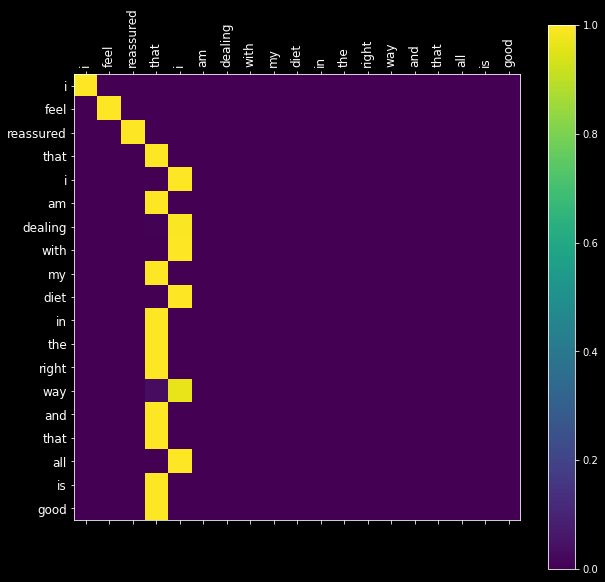

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(text.split(), attns[-1][0])

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Feature exctracting

Теперь другой подход: загрузим модель, которая обучалась решать задачу `Language Modeling`. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

model_1.resize_token_embeddings(len(tokenizer))

Заморозим слои трансформера и изменим немного выходной слой - добавим дополнительный линейный слой и `ReLU`

In [ ]:
model_1.score = nn.Sequential(nn.Linear(768, 768), 
                              nn.Dropout(.1),
                              nn.ReLU(),
                              nn.Linear(768, 8))

# заморозим слои трансфомера
for param in model_1.transformer.parameters():
    param.requires_grad = False

Проверим выходы модели:

In [ ]:
batch = next(iter(train_loader))

model_1 = model_1.to(device)

outputs = model_1(
        input_ids=batch['input_ids'].to(device),
        attention_mask=batch['attention_mask'].to(device),
        labels=batch['labels'].to(device)
)

In [ ]:
lr = 2e-4
optimizer = torch.optim.AdamW(model_1.parameters(), weight_decay=0.005)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
clip = 1
num_epochs = 20

total_steps = len(train_loader) * num_epochs

lr_scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Train loop
for e in range(num_epochs):
    
    model_1.train()
    train_loss = 0
    correct_predictions = 0
    processed_train = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    pbar.set_description(f"Epoch {e + 1}")
    for idx, batch in pbar:

        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch["labels"].to(device)

        outputs = model_1(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
          )

        loss, logits = outputs[:2]
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_1.parameters(), clip)

        optimizer.step()
        lr_scheduler.step()
        preds = logits.argmax(-1)
        correct_predictions += torch.sum(preds == targets)
        processed_train += input_ids.size(0)
        
    train_accuracy = correct_predictions.double() / processed_train
    train_loss = train_loss / processed_train

    valid_loss = 0
    valid_acc = 0
    processed_val = 0
    model_1.eval()

    with torch.no_grad():
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False)
        pbar.set_description(f"Epoch {e + 1}")
        for idx, batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch["labels"].to(device)

            outputs = model_1(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
           )

            loss, logits = outputs[:2]

            preds = logits.argmax(-1)
            valid_acc += torch.sum(preds == targets)
            valid_loss += loss.item() * input_ids.size(0)
            processed_val += input_ids.size(0)
        val_accuracy = valid_acc.double() / processed_val
        val_loss = valid_loss / processed_val


    print(f"Train Loss: {train_loss:.2f}, "
          f"Train Acc: {train_accuracy:.2f}, "
          f"Valid Loss: {val_loss:.2f}, "
          f"Valid Acc: {val_accuracy:.2f}")
        
# Testing

test_acc = 0
test_loss = 0
model_1.eval()
processed_test = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch["labels"].to(device)

        outputs = model_1(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=targets
           )

        loss, logits = outputs[:2]
        processed_test += input_ids.size(0)
        preds = logits.argmax(-1)
        test_acc += torch.sum(preds == targets)
        test_loss += loss.item() * input_ids.size(0)
    test_accuracy = test_acc.double() / processed_test
    test_loss = test_loss  / processed_test

print(f"Test Loss: {test_loss:.2f} ")
print(f"Test Acc: {test_accuracy:.2f}")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.60, Train Acc: 0.35, Valid Loss: 1.51, Valid Acc: 0.45


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.52, Train Acc: 0.40, Valid Loss: 1.49, Valid Acc: 0.41


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.49, Train Acc: 0.42, Valid Loss: 1.42, Valid Acc: 0.48


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.47, Train Acc: 0.42, Valid Loss: 1.45, Valid Acc: 0.46


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.47, Train Acc: 0.43, Valid Loss: 1.37, Valid Acc: 0.46


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.46, Train Acc: 0.43, Valid Loss: 1.36, Valid Acc: 0.51


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.44, Train Acc: 0.44, Valid Loss: 1.33, Valid Acc: 0.50


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.44, Train Acc: 0.44, Valid Loss: 1.33, Valid Acc: 0.51


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.43, Train Acc: 0.44, Valid Loss: 1.32, Valid Acc: 0.51


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.42, Train Acc: 0.45, Valid Loss: 1.29, Valid Acc: 0.51


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.41, Train Acc: 0.44, Valid Loss: 1.28, Valid Acc: 0.52


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.41, Train Acc: 0.45, Valid Loss: 1.29, Valid Acc: 0.52


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.40, Train Acc: 0.45, Valid Loss: 1.28, Valid Acc: 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.40, Train Acc: 0.46, Valid Loss: 1.27, Valid Acc: 0.52


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.39, Train Acc: 0.45, Valid Loss: 1.31, Valid Acc: 0.55


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.39, Train Acc: 0.45, Valid Loss: 1.29, Valid Acc: 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.39, Train Acc: 0.46, Valid Loss: 1.27, Valid Acc: 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.38, Train Acc: 0.46, Valid Loss: 1.26, Valid Acc: 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.37, Train Acc: 0.46, Valid Loss: 1.25, Valid Acc: 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.38, Train Acc: 0.46, Valid Loss: 1.26, Valid Acc: 0.53


  0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.24 
Test Acc: 0.54


In [ ]:
text = emotion_dataset["test"]["text"][42] 
tokens = tokenizer.tokenize(text)

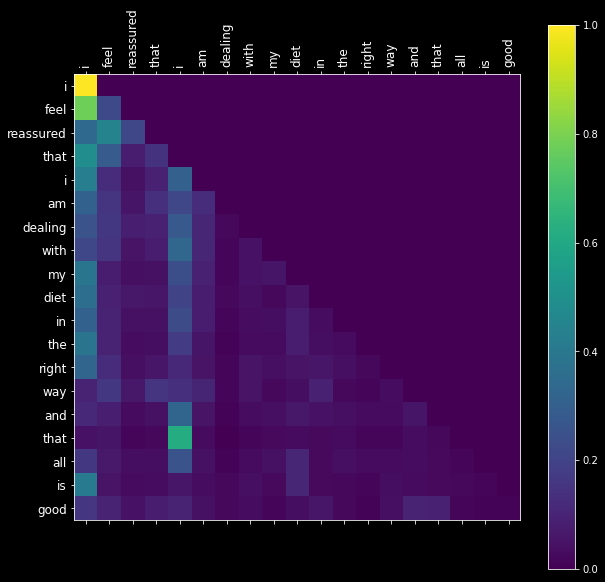

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(text.split(), attns[-1][0])

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Отчет

В результате проделанной работы, мы получили опыт взаимодействия с моделями трансформеров и с библиотекой `HuggingFace🤗`. Нам необходимо было решить с помощью модели `GPT2` простую задачу (анализ сентимента).  


Мы пробовали два подхода решения данной задачи.  

1. `Fine-tuning`. Мы работали с моделью `GPT2ForSequenceClassification` на базе `distilbert2` - все слои были разморожены, по ним производился рассчет градиента. В результате обучения в течение 20 эпох - мы получили достаточно неплозие результаты `Accuracy` на тестовой выборке составил - `0.81`. В модель передавали маску, токенизированные предложения и лейблы - на выходе получали `loss` и `labels` - далее уже осуществляли подсчет верных значений. В результате - получили достаточно четкую карту внимания - модель обращала внимание в основном на совокупность существительных, местоимений и глаголов, на первую часть предложения.


2. `Feature-extracting`. Второй подход основывался на том, чтобы взять готовую модель, ранее обученную - мы брали снова  `GPT2ForSequenceClassification` на базе `distilbert2` - и получить ответы на основе весов, уже полученных в этой модели. Мы заменили только слой классификатора на:

  ```python

  nn.Sequential(nn.Linear(768, 768), 
                                nn.Dropout(.1),
                                nn.ReLU(),
                                nn.Linear(768, 8))


  ```

  Остальные слои, которые принадлежат трансформеру - были заморожены. В результате обучения, получили достаточно низкие результаты - `0.54`. Данные веса не подошли под нашу задачу, обучение классификатора не помогло сильно улучшить результаты. Мы получили достаточно размытую карту внимания - наибольшему вниманию модель уделяла только местоимениям и глаголу



  Таким образом, дообучение трансформера (`fine-tuning`) способствует сильному улучшению качества выдаваемых эмбеддингов и на выходе - мы получаем лучший классификатор. 

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___
